In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SwinModel
from transformers.models.swin.modeling_swin import SwinLayer

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import torch
import torch.nn as nn
from transformers.models.swin.modeling_swin import SwinPatchEmbeddings, SwinPatchMerging, SwinLayer
from transformers import SwinConfig
from typing import Tuple, Optional
# --- Cài đặt tham số cố định ---
IMG_SIZE = 320 
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
SEED = 42
BATCH_SIZE = 2
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Đường dẫn dữ liệu (Thay đổi nếu cần) ---
train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

# --- Thu thập đường dẫn tệp ảnh và mask ---
train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


In [2]:
class CrackDetectionDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transform=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_filenames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 0, 255.0, 0.0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        mask = mask / 255.0
        mask = mask.unsqueeze(0)

        return img, mask

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
class PatchExpanding(nn.Module):
    def __init__(self, input_resolution: Tuple[int, int], dim: int, return_vector: bool = True):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(dim // 2)
        self.return_vector = return_vector

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        H, W = self.input_resolution
        x = x.view(-1, H, W, self.dim)
        x = self.expand(x)
        B, H, W, C = x.shape
        x = x.view(B, H, W, 2, 2, C // 4)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * 2, W * 2, C // 4)
        x = self.norm(x)
        if self.return_vector:
            x = x.view(B, -1, C // 4)
        return x


class FinalPatchExpanding(nn.Module):
    def __init__(self, dim: int, scale_factor: int = 4):
        super().__init__()
        self.scale_factor = scale_factor
        self.output_dim = dim // scale_factor

        expand_dim = self.output_dim * (scale_factor**2)
        self.expand = nn.Linear(dim, expand_dim, bias=False)

        self.norm = nn.LayerNorm(self.output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        H = W = int(np.sqrt(L))
        x_expanded = self.expand(x)

        x_reshaped = x_expanded.view(B, H, W, self.scale_factor, self.scale_factor, self.output_dim)

        x_permuted = x_reshaped.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * self.scale_factor, W * self.scale_factor, self.output_dim)

        x_normed = self.norm(x_permuted)

        output = x_normed.view(B, -1, self.output_dim)
        
        return output


class SkipAttention(nn.Module):
    def __init__(self, query_dim: int, context_dim: Optional[int] = None, num_heads: int = 8, dim_head: int = 64):
        super().__init__()
        if context_dim is None:
            context_dim = query_dim
        
        self.attn = nn.MultiheadAttention(embed_dim=query_dim, num_heads=num_heads, 
                                          kdim=context_dim, vdim=context_dim, 
                                          batch_first=True)
        self.norm = nn.LayerNorm(query_dim)

    def forward(self, query: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        attn_output, _ = self.attn(query=query, key=context, value=context)
        return self.norm(query + attn_output)


class ResidualSwinBlock(nn.Module):
    def __init__(self, config: SwinConfig, dim: int, input_resolution: Tuple[int, int], num_layers: int, num_heads: int):
        super().__init__()
        self.layers = nn.ModuleList([
            SwinLayer(
                config=config, 
                dim=dim, 
                input_resolution=input_resolution, 
                num_heads=num_heads, 
                shift_size=0 if (i % 2 == 0) else config.window_size // 2
            ) for i in range(num_layers)
        ])
        
    def forward(self, x: torch.Tensor, input_resolution: Tuple[int, int]) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            x = layer(x, input_resolution)[0]
        return x + residual


class iSwinUnet(nn.Module):
    def __init__(self, num_classes: int = 1, img_size: int = 320, pretrained: bool = True):
        super().__init__()
        self.num_classes = num_classes
        self.img_size = img_size
        
        # --- Config ---
        config = SwinConfig(image_size=img_size, patch_size=4, window_size=7)
        self.config = config
        self.encoder_channels = [config.embed_dim * (2**i) for i in range(len(config.depths))]

        # --- Encoder ---
        self.patch_embed = SwinPatchEmbeddings(config)
        self.pos_drop = nn.Dropout(p=config.hidden_dropout_prob)

        self.encoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])
        self.merge1 = SwinPatchMerging(input_resolution=(img_size//4, img_size//4), dim=self.encoder_channels[0])
        
        self.encoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])
        self.merge2 = SwinPatchMerging(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])

        self.encoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])
        self.merge3 = SwinPatchMerging(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        
        self.bottleneck = ResidualSwinBlock(config, self.encoder_channels[3], (img_size//32, img_size//32), config.depths[3], config.num_heads[3])

        self.decoder_expand3 = PatchExpanding(input_resolution=(img_size//32, img_size//32), dim=self.encoder_channels[3])
        self.skip_attn3 = SkipAttention(query_dim=self.encoder_channels[2], context_dim=self.encoder_channels[2], num_heads=config.num_heads[2])
        self.decoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])

        self.decoder_expand2 = PatchExpanding(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        self.skip_attn2 = SkipAttention(query_dim=self.encoder_channels[1], context_dim=self.encoder_channels[1], num_heads=config.num_heads[1])
        self.decoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])

        self.decoder_expand1 = PatchExpanding(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])
        self.skip_attn1 = SkipAttention(query_dim=self.encoder_channels[0], context_dim=self.encoder_channels[0], num_heads=config.num_heads[0])
        self.decoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])

        self.final_expand = FinalPatchExpanding(dim=self.encoder_channels[0], scale_factor=4)
        self.final_conv = nn.Conv2d(self.final_expand.output_dim, num_classes, kernel_size=1)

        if pretrained:
            self.load_pretrained_weights()

    def load_pretrained_weights(self):
            print("Loading pretrained weights for Swin-Tiny encoder...")
            try:
                swin_original = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
                original_state_dict = swin_original.state_dict()

                model_state_dict = self.state_dict()

                prefix_mapping = {
                    'embeddings.patch_embeddings': 'patch_embed',
                    'encoder.layers.0.downsample': 'merge1',
                    'encoder.layers.1.downsample': 'merge2',
                    'encoder.layers.2.downsample': 'merge3',
                }

                stage_mapping = {
                    'encoder.layers.0': 'encoder_stage1',
                    'encoder.layers.1': 'encoder_stage2',
                    'encoder.layers.2': 'encoder_stage3',
                    'encoder.layers.3': 'bottleneck',
                }

                loaded_count = 0
                
                orig_pos_embed_key = 'embeddings.absolute_position_embedding'
                if orig_pos_embed_key in original_state_dict:
                    orig_pos_embed = original_state_dict[orig_pos_embed_key]
                    target_pos_embed = model_state_dict[orig_pos_embed_key]
                    if orig_pos_embed.shape != target_pos_embed.shape:
                        print(f"Interpolating absolute position embedding due to size mismatch...")
                        orig_pos_embed_spatial = orig_pos_embed[0, 1:, :].permute(1, 0)

                        H_orig = W_orig = int((orig_pos_embed.shape[1] - 1) ** 0.5)
                        orig_pos_embed_spatial = orig_pos_embed_spatial.view(1, -1, H_orig, W_orig)
                        H_target = W_target = int((target_pos_embed.shape[1] - 1) ** 0.5)
                        interp_pos_embed = nn.functional.interpolate(
                            orig_pos_embed_spatial, size=(H_target, W_target), mode='bicubic', align_corners=False
                        )
                        interp_pos_embed = interp_pos_embed.view(1, -1, H_target * W_target).permute(0, 2, 1)
                        # Thêm lại token [CLS]
                        final_pos_embed = torch.cat((orig_pos_embed[0, 0:1, :], interp_pos_embed[0]), dim=0).unsqueeze(0)
                        model_state_dict[orig_pos_embed_key] = final_pos_embed
                        loaded_count += 1
                    del original_state_dict[orig_pos_embed_key]

                for key_orig, value in original_state_dict.items():
                    new_key = None

                    if 'pooler' in key_orig:
                        continue

                    for old_prefix, new_prefix in prefix_mapping.items():
                        if key_orig.startswith(old_prefix):
                            new_key = key_orig.replace(old_prefix, new_prefix)
                            break

                    if new_key is None:
                        for old_stage_prefix, new_stage_prefix in stage_mapping.items():
                            if key_orig.startswith(old_stage_prefix):
                                remainder = key_orig[len(old_stage_prefix):]
                                if remainder.startswith('.blocks'):
                                    remainder = remainder.replace('.blocks', '', 1)
                                    new_key = f"{new_stage_prefix}.layers{remainder}"
                                break

                    if new_key is None:
                        if key_orig.startswith('embeddings.norm'):
                            new_key = key_orig.replace('embeddings.norm', 'patch_embed.norm')
                        elif key_orig.startswith('encoder.norm'):
                            continue

                    if new_key and new_key in model_state_dict and model_state_dict[new_key].shape == value.shape:
                        model_state_dict[new_key] = value
                        loaded_count += 1
                    else:
                        pass

                self.load_state_dict(model_state_dict, strict=False)

                expected_keys = len([k for k in swin_original.state_dict().keys() if 'pooler' not in k and 'encoder.norm' not in k])
                print(f"Successfully loaded {loaded_count}/{expected_keys} tensors from pretrained Swin-Tiny.")
                print("   (Any unloaded tensors are expected to be from the decoder and final layers).")

            except Exception as e:
                print(f"ERROR: Could not load pretrained weights. Error: {e}. Training from scratch.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s1_skip = self.patch_embed(x)[0]
        s1_skip = self.pos_drop(s1_skip)
        
        s1_out = self.encoder_stage1(s1_skip, (self.img_size//4, self.img_size//4))
        s2_in = self.merge1(s1_out, (self.img_size//4, self.img_size//4))
        
        s2_out = self.encoder_stage2(s2_in, (self.img_size//8, self.img_size//8))
        s3_in = self.merge2(s2_out, (self.img_size//8, self.img_size//8))

        s3_out = self.encoder_stage3(s3_in, (self.img_size//16, self.img_size//16))
        b_in = self.merge3(s3_out, (self.img_size//16, self.img_size//16))
        
        b_out = self.bottleneck(b_in, (self.img_size//32, self.img_size//32))

        d3_in = self.decoder_expand3(b_out)
        d3_in = self.skip_attn3(query=d3_in, context=s3_out)
        d3_out = self.decoder_stage3(d3_in, (self.img_size//16, self.img_size//16))

        d2_in = self.decoder_expand2(d3_out)
        d2_in = self.skip_attn2(query=d2_in, context=s2_out)
        d2_out = self.decoder_stage2(d2_in, (self.img_size//8, self.img_size//8))

        d1_in = self.decoder_expand1(d2_out)
        d1_in = self.skip_attn1(query=d1_in, context=s1_out)
        d1_out = self.decoder_stage1(d1_in, (self.img_size//4, self.img_size//4))
        
        final_features = self.final_expand(d1_out)
        
        B, L, C = final_features.shape
        H = W = int(np.sqrt(L))
        final_features = final_features.permute(0, 2, 1).contiguous().view(B, C, H, W)
        
        output = self.final_conv(final_features)
        
        return output

In [4]:

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Mô hình trả về logits, cần đưa qua sigmoid để có xác suất trong khoảng (0, 1)
        inputs = torch.sigmoid(inputs)
        
        # Làm phẳng inputs và targets để tính toán dễ dàng
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Tính toán intersection (phần giao) và union (phần hợp)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        # Tính IoU, thêm smooth để tránh chia cho 0
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        # Loss là 1 - IoU, vì mục tiêu của chúng ta là tối đa hóa IoU
        return 1 - iou

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Mô hình trả về logits, cần đưa qua sigmoid để có xác suất trong khoảng (0, 1)
        inputs = torch.sigmoid(inputs)
        
        # Làm phẳng inputs và targets để tính toán dễ dàng
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Tính toán intersection
        intersection = (inputs * targets).sum()
        
        # Tính Dice coefficient
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        # Loss là 1 - Dice, vì mục tiêu của chúng ta là tối đa hóa Dice
        return 1 - dice


def calculate_metrics(predicted_masks, true_masks, smooth=1e-6):
    predicted_masks = predicted_masks.view(-1)
    true_masks = true_masks.view(-1)
    
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    dice = (2. * intersection + smooth) / (predicted_masks.sum() + true_masks.sum() + smooth)
    
    return iou.item(), dice.item()

In [5]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, callbacks_config, start_epoch=0, best_val_iou=0.0, history=None):
    best_iou = best_val_iou
    patience_counter = 0
    checkpoint_path = callbacks_config.get('checkpoint_path', 'model_best.pth')
    
    if history is None:
        history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': [], 'lr': []}

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss, train_iou = 0.0, 0.0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
            
            batch_iou, _ = calculate_metrics(predicted_masks, masks)
            train_iou += batch_iou
            
            loop.set_postfix(loss=loss.item(), iou=batch_iou)

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_iou'].append(train_iou / len(train_loader))
        
        model.eval()
        val_loss, val_iou = 0.0, 0.0
        
        loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, masks in loop:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
                
                batch_iou, _ = calculate_metrics(predicted_masks, masks)
                val_iou += batch_iou

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        
        scheduler.step(avg_val_loss) # Sử dụng validation loss cho scheduler
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train -> Loss: {history['train_loss'][-1]:.4f}, IoU: {history['train_iou'][-1]:.4f}")
        print(f"  Val   -> Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}")
        print(f"  LR: {current_lr:.8f}")

        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            patience_counter = 0
            print(f"🚀 New best validation IoU: {best_iou:.4f}. Saving model...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_iou': best_iou,
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history
            }, checkpoint_path)
        else:
            patience_counter += 1
            print(f"Validation IoU did not improve. Patience: {patience_counter}/{callbacks_config['patience']}")
            if patience_counter >= callbacks_config['patience']:
                print("Early stopping!")
                break
    return history

# --- Hàm vẽ biểu đồ (Đã chỉnh sửa chỉ dùng IoU) ---
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Sửa đổi: Tạo một hàng 3 cột cho 3 biểu đồ
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Biểu đồ 1: Loss
    axs[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    axs[0].plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].legend()

    # Biểu đồ 2: IoU
    axs[1].plot(epochs, history['train_iou'], 'o-', label='Train IoU')
    axs[1].plot(epochs, history['val_iou'], 'o-', label='Validation IoU')
    axs[1].set_title('Training and Validation IoU')
    axs[1].set(xlabel='Epoch', ylabel='IoU')
    axs[1].legend()

    axs[2].plot(epochs, history['lr'], 'o-', label='Learning Rate', color='purple')
    axs[2].set_title('Learning Rate per Epoch')
    axs[2].set(xlabel='Epoch', ylabel='Learning Rate')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            preds = (preds > threshold).float()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_targets.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"IoU:       {iou:.4f}")


Initializing iSwinUnet model (paper version)...
Loading pretrained weights for Swin-Tiny encoder...
✅ Successfully loaded 227/231 tensors from pretrained Swin-Tiny.
   (Any unloaded tensors are expected to be from the decoder and final layers).
!!! USING BCEWithLogitsLoss with pos_weight=30 !!!
Model has 41,657,773 trainable parameters.
Checkpoint 'iswin_unet_v2_diceloss.pth' found. Resuming training...


C:\Users\Admin\AppData\Local\Temp\ipykernel_9128\3349666728.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE

Resuming from Epoch 56 with Best Val IoU: 0.5169
Loaded training history with 56 epochs.

--- Starting Training ---


Epoch 57/200 [Val]: 100%|██████████| 200/200 [00:22<00:00,  9.00it/s]


Epoch 57 Summary:
  Train -> Loss: 0.2162, IoU: 0.6605
  Val   -> Loss: 0.3365, IoU: 0.5154
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/30


Epoch 58/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.21it/s]


Epoch 58 Summary:
  Train -> Loss: 0.2149, IoU: 0.6615
  Val   -> Loss: 0.3374, IoU: 0.5145
  LR: 0.00005000
Validation IoU did not improve. Patience: 2/30


Epoch 59/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Epoch 59 Summary:
  Train -> Loss: 0.2118, IoU: 0.6661
  Val   -> Loss: 0.3388, IoU: 0.5130
  LR: 0.00005000
Validation IoU did not improve. Patience: 3/30


Epoch 60/200 [Val]: 100%|██████████| 200/200 [00:19<00:00, 10.45it/s]


Epoch 60 Summary:
  Train -> Loss: 0.2145, IoU: 0.6632
  Val   -> Loss: 0.3357, IoU: 0.5159
  LR: 0.00002500
Validation IoU did not improve. Patience: 4/30


Epoch 61/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.35it/s]


Epoch 61 Summary:
  Train -> Loss: 0.2058, IoU: 0.6744
  Val   -> Loss: 0.3325, IoU: 0.5196
  LR: 0.00002500
🚀 New best validation IoU: 0.5196. Saving model...


Epoch 62/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.56it/s]


Epoch 62 Summary:
  Train -> Loss: 0.2031, IoU: 0.6772
  Val   -> Loss: 0.3311, IoU: 0.5210
  LR: 0.00002500
🚀 New best validation IoU: 0.5210. Saving model...


Epoch 63/200 [Val]: 100%|██████████| 200/200 [00:19<00:00, 10.18it/s]


Epoch 63 Summary:
  Train -> Loss: 0.2055, IoU: 0.6750
  Val   -> Loss: 0.3358, IoU: 0.5162
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/30


Epoch 64/200 [Val]: 100%|██████████| 200/200 [00:19<00:00, 10.04it/s]


Epoch 64 Summary:
  Train -> Loss: 0.2033, IoU: 0.6771
  Val   -> Loss: 0.3334, IoU: 0.5186
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/30


Epoch 65/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.79it/s]


Epoch 65 Summary:
  Train -> Loss: 0.2015, IoU: 0.6798
  Val   -> Loss: 0.3349, IoU: 0.5171
  LR: 0.00002500
Validation IoU did not improve. Patience: 3/30


Epoch 66/200 [Val]: 100%|██████████| 200/200 [00:19<00:00, 10.03it/s]


Epoch 66 Summary:
  Train -> Loss: 0.2033, IoU: 0.6778
  Val   -> Loss: 0.3342, IoU: 0.5180
  LR: 0.00002500
Validation IoU did not improve. Patience: 4/30


Epoch 67/200 [Val]: 100%|██████████| 200/200 [00:19<00:00, 10.22it/s]


Epoch 67 Summary:
  Train -> Loss: 0.2019, IoU: 0.6799
  Val   -> Loss: 0.3329, IoU: 0.5192
  LR: 0.00002500
Validation IoU did not improve. Patience: 5/30


Epoch 68/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.60it/s]


Epoch 68 Summary:
  Train -> Loss: 0.2010, IoU: 0.6803
  Val   -> Loss: 0.3315, IoU: 0.5204
  LR: 0.00001250
Validation IoU did not improve. Patience: 6/30


Epoch 69/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.16it/s]


Epoch 69 Summary:
  Train -> Loss: 0.2009, IoU: 0.6813
  Val   -> Loss: 0.3305, IoU: 0.5216
  LR: 0.00001250
🚀 New best validation IoU: 0.5216. Saving model...


Epoch 70/200 [Val]: 100%|██████████| 200/200 [00:19<00:00, 10.33it/s]


Epoch 70 Summary:
  Train -> Loss: 0.1947, IoU: 0.6883
  Val   -> Loss: 0.3307, IoU: 0.5216
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/30


Epoch 71/200 [Val]: 100%|██████████| 200/200 [00:27<00:00,  7.25it/s]


Epoch 71 Summary:
  Train -> Loss: 0.1958, IoU: 0.6883
  Val   -> Loss: 0.3304, IoU: 0.5217
  LR: 0.00001250
🚀 New best validation IoU: 0.5217. Saving model...


Epoch 72/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.59it/s]


Epoch 72 Summary:
  Train -> Loss: 0.1951, IoU: 0.6883
  Val   -> Loss: 0.3299, IoU: 0.5221
  LR: 0.00001250
🚀 New best validation IoU: 0.5221. Saving model...


Epoch 73/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.63it/s]


Epoch 73 Summary:
  Train -> Loss: 0.1920, IoU: 0.6919
  Val   -> Loss: 0.3297, IoU: 0.5221
  LR: 0.00001250
🚀 New best validation IoU: 0.5221. Saving model...


Epoch 74/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.91it/s]


Epoch 74 Summary:
  Train -> Loss: 0.1881, IoU: 0.6972
  Val   -> Loss: 0.3317, IoU: 0.5205
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/30


Epoch 75/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.97it/s]


Epoch 75 Summary:
  Train -> Loss: 0.1944, IoU: 0.6896
  Val   -> Loss: 0.3302, IoU: 0.5219
  LR: 0.00001250
Validation IoU did not improve. Patience: 2/30


Epoch 76/200 [Val]: 100%|██████████| 200/200 [00:20<00:00,  9.68it/s]


Epoch 76 Summary:
  Train -> Loss: 0.1893, IoU: 0.6961
  Val   -> Loss: 0.3311, IoU: 0.5209
  LR: 0.00001250
Validation IoU did not improve. Patience: 3/30


Epoch 77/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.59it/s]


Epoch 77 Summary:
  Train -> Loss: 0.1921, IoU: 0.6928
  Val   -> Loss: 0.3295, IoU: 0.5224
  LR: 0.00001250
🚀 New best validation IoU: 0.5224. Saving model...


Epoch 78/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.70it/s]


Epoch 78 Summary:
  Train -> Loss: 0.1929, IoU: 0.6915
  Val   -> Loss: 0.3306, IoU: 0.5214
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/30


Epoch 79/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.74it/s]


Epoch 79 Summary:
  Train -> Loss: 0.1945, IoU: 0.6899
  Val   -> Loss: 0.3272, IoU: 0.5249
  LR: 0.00001250
🚀 New best validation IoU: 0.5249. Saving model...


Epoch 80/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.00it/s]


Epoch 80 Summary:
  Train -> Loss: 0.1896, IoU: 0.6954
  Val   -> Loss: 0.3292, IoU: 0.5231
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/30


Epoch 81/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.93it/s]


Epoch 81 Summary:
  Train -> Loss: 0.1898, IoU: 0.6958
  Val   -> Loss: 0.3290, IoU: 0.5229
  LR: 0.00001250
Validation IoU did not improve. Patience: 2/30


Epoch 82/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


Epoch 82 Summary:
  Train -> Loss: 0.1862, IoU: 0.6999
  Val   -> Loss: 0.3292, IoU: 0.5228
  LR: 0.00001250
Validation IoU did not improve. Patience: 3/30


Epoch 83/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


Epoch 83 Summary:
  Train -> Loss: 0.1939, IoU: 0.6914
  Val   -> Loss: 0.3304, IoU: 0.5218
  LR: 0.00001250
Validation IoU did not improve. Patience: 4/30


Epoch 84/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


Epoch 84 Summary:
  Train -> Loss: 0.1865, IoU: 0.6995
  Val   -> Loss: 0.3304, IoU: 0.5220
  LR: 0.00001250
Validation IoU did not improve. Patience: 5/30


Epoch 85/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.94it/s]


Epoch 85 Summary:
  Train -> Loss: 0.1879, IoU: 0.6974
  Val   -> Loss: 0.3303, IoU: 0.5218
  LR: 0.00000625
Validation IoU did not improve. Patience: 6/30


Epoch 86/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.73it/s]


Epoch 86 Summary:
  Train -> Loss: 0.1904, IoU: 0.6952
  Val   -> Loss: 0.3282, IoU: 0.5241
  LR: 0.00000625
Validation IoU did not improve. Patience: 7/30


Epoch 87/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.02it/s]


Epoch 87 Summary:
  Train -> Loss: 0.1878, IoU: 0.6987
  Val   -> Loss: 0.3288, IoU: 0.5236
  LR: 0.00000625
Validation IoU did not improve. Patience: 8/30


Epoch 88/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.00it/s]


Epoch 88 Summary:
  Train -> Loss: 0.1862, IoU: 0.7004
  Val   -> Loss: 0.3279, IoU: 0.5242
  LR: 0.00000625
Validation IoU did not improve. Patience: 9/30


Epoch 89/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


Epoch 89 Summary:
  Train -> Loss: 0.1850, IoU: 0.7017
  Val   -> Loss: 0.3298, IoU: 0.5227
  LR: 0.00000625
Validation IoU did not improve. Patience: 10/30


Epoch 90/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


Epoch 90 Summary:
  Train -> Loss: 0.1824, IoU: 0.7046
  Val   -> Loss: 0.3293, IoU: 0.5231
  LR: 0.00000625
Validation IoU did not improve. Patience: 11/30


Epoch 91/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.98it/s]


Epoch 91 Summary:
  Train -> Loss: 0.1878, IoU: 0.6982
  Val   -> Loss: 0.3279, IoU: 0.5241
  LR: 0.00000313
Validation IoU did not improve. Patience: 12/30


Epoch 92/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


Epoch 92 Summary:
  Train -> Loss: 0.1881, IoU: 0.6986
  Val   -> Loss: 0.3286, IoU: 0.5235
  LR: 0.00000313
Validation IoU did not improve. Patience: 13/30


Epoch 93/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.00it/s]


Epoch 93 Summary:
  Train -> Loss: 0.1848, IoU: 0.7020
  Val   -> Loss: 0.3294, IoU: 0.5230
  LR: 0.00000313
Validation IoU did not improve. Patience: 14/30


Epoch 94/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.02it/s]


Epoch 94 Summary:
  Train -> Loss: 0.1782, IoU: 0.7100
  Val   -> Loss: 0.3294, IoU: 0.5230
  LR: 0.00000313
Validation IoU did not improve. Patience: 15/30


Epoch 95/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


Epoch 95 Summary:
  Train -> Loss: 0.1843, IoU: 0.7035
  Val   -> Loss: 0.3287, IoU: 0.5235
  LR: 0.00000313
Validation IoU did not improve. Patience: 16/30


Epoch 96/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.00it/s]


Epoch 96 Summary:
  Train -> Loss: 0.1834, IoU: 0.7041
  Val   -> Loss: 0.3289, IoU: 0.5234
  LR: 0.00000313
Validation IoU did not improve. Patience: 17/30


Epoch 97/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


Epoch 97 Summary:
  Train -> Loss: 0.1793, IoU: 0.7089
  Val   -> Loss: 0.3297, IoU: 0.5227
  LR: 0.00000156
Validation IoU did not improve. Patience: 18/30


Epoch 98/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.66it/s]


Epoch 98 Summary:
  Train -> Loss: 0.1808, IoU: 0.7072
  Val   -> Loss: 0.3299, IoU: 0.5224
  LR: 0.00000156
Validation IoU did not improve. Patience: 19/30


Epoch 99/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.82it/s]


Epoch 99 Summary:
  Train -> Loss: 0.1777, IoU: 0.7109
  Val   -> Loss: 0.3296, IoU: 0.5227
  LR: 0.00000156
Validation IoU did not improve. Patience: 20/30


Epoch 100/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 100 Summary:
  Train -> Loss: 0.1829, IoU: 0.7051
  Val   -> Loss: 0.3300, IoU: 0.5224
  LR: 0.00000156
Validation IoU did not improve. Patience: 21/30


Epoch 101/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


Epoch 101 Summary:
  Train -> Loss: 0.1798, IoU: 0.7091
  Val   -> Loss: 0.3294, IoU: 0.5229
  LR: 0.00000156
Validation IoU did not improve. Patience: 22/30


Epoch 102/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.95it/s]


Epoch 102 Summary:
  Train -> Loss: 0.1836, IoU: 0.7046
  Val   -> Loss: 0.3295, IoU: 0.5228
  LR: 0.00000156
Validation IoU did not improve. Patience: 23/30


Epoch 103/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.95it/s]


Epoch 103 Summary:
  Train -> Loss: 0.1834, IoU: 0.7053
  Val   -> Loss: 0.3291, IoU: 0.5232
  LR: 0.00000078
Validation IoU did not improve. Patience: 24/30


Epoch 104/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


Epoch 104 Summary:
  Train -> Loss: 0.1797, IoU: 0.7091
  Val   -> Loss: 0.3294, IoU: 0.5229
  LR: 0.00000078
Validation IoU did not improve. Patience: 25/30


Epoch 105/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


Epoch 105 Summary:
  Train -> Loss: 0.1839, IoU: 0.7036
  Val   -> Loss: 0.3292, IoU: 0.5230
  LR: 0.00000078
Validation IoU did not improve. Patience: 26/30


Epoch 106/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.00it/s]


Epoch 106 Summary:
  Train -> Loss: 0.1819, IoU: 0.7063
  Val   -> Loss: 0.3294, IoU: 0.5229
  LR: 0.00000078
Validation IoU did not improve. Patience: 27/30


Epoch 107/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


Epoch 107 Summary:
  Train -> Loss: 0.1787, IoU: 0.7104
  Val   -> Loss: 0.3297, IoU: 0.5226
  LR: 0.00000078
Validation IoU did not improve. Patience: 28/30


Epoch 108/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


Epoch 108 Summary:
  Train -> Loss: 0.1814, IoU: 0.7069
  Val   -> Loss: 0.3296, IoU: 0.5227
  LR: 0.00000078
Validation IoU did not improve. Patience: 29/30


Epoch 109/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


Epoch 109 Summary:
  Train -> Loss: 0.1793, IoU: 0.7097
  Val   -> Loss: 0.3295, IoU: 0.5227
  LR: 0.00000039
Validation IoU did not improve. Patience: 30/30
Early stopping!

--- Training complete. ---
Plotting training history...


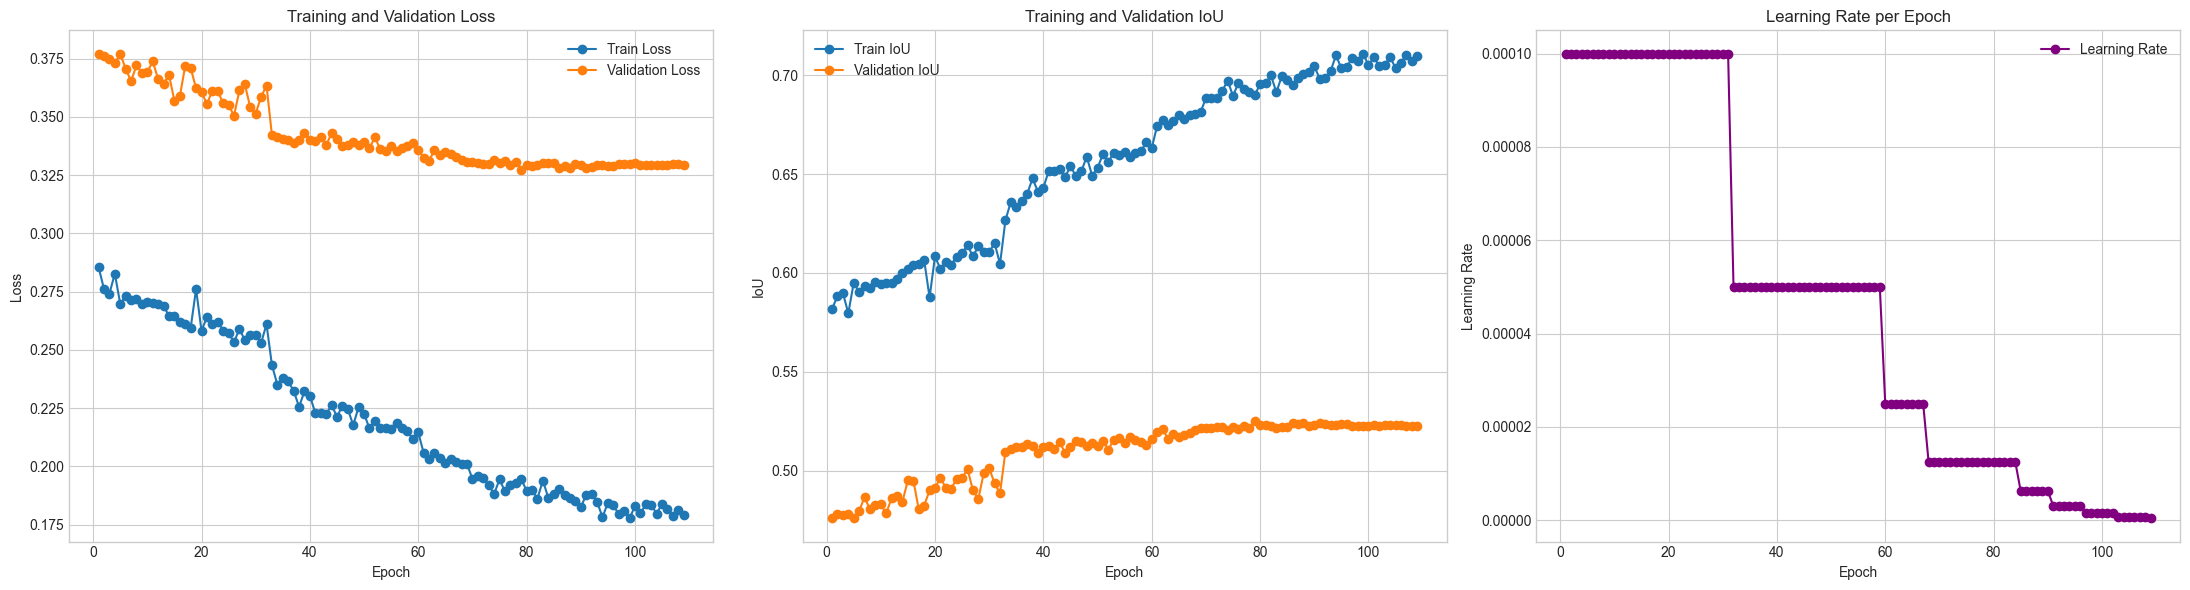


--- Evaluating the best model on the validation set ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_9128\3349666728.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH)['model_sta


--- Evaluation Metrics ---
Precision: 0.7207
Recall:    0.7486
F1-score:  0.7344
IoU:       0.5802


In [7]:
if __name__ == '__main__':
    # --- Chuẩn bị dữ liệu ---
    train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
    train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
    val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
    val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])

    train_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    train_dataset = CrackDetectionDataset(train_img_paths, train_mask_paths, transform=train_transform)
    val_dataset = CrackDetectionDataset(val_img_paths, val_mask_paths, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    # --- Khởi tạo Model, Optimizer, Loss ---
    print("Initializing iSwinUnet model (paper version)...")
    model = iSwinUnet(num_classes=1, img_size=IMG_SIZE, pretrained=True).to(DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    
    pos_weight_value = 30
    criterion = DiceLoss()
    
    print("="*50)
    print(f"!!! USING BCEWithLogitsLoss with pos_weight={pos_weight_value} !!!")
    print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")
    print("="*50)

    CHECKPOINT_PATH = 'iswin_unet_v2_diceloss.pth'
    
    callbacks_config = {'patience': 30, 'checkpoint_path': CHECKPOINT_PATH}

    # Khởi tạo các biến trạng thái
    start_epoch = 0
    best_val_iou = 0.0
    history = None
    
    # Logic để tải checkpoint và huấn luyện tiếp (resume training)
    if os.path.exists(CHECKPOINT_PATH):
        print(f"Checkpoint '{CHECKPOINT_PATH}' found. Resuming training...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        
        # Tải trạng thái của model
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Tải trạng thái của optimizer
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Tải trạng thái của scheduler (nếu có)
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Khôi phục các biến số của quá trình huấn luyện
        start_epoch = checkpoint['epoch'] + 1
        # Dùng .get() để tương thích ngược với checkpoint cũ có thể chưa lưu các giá trị này
        best_val_iou = checkpoint.get('best_val_iou', 0.0) 
        history = checkpoint.get('history', None)
        
        model.to(DEVICE) # Đảm bảo model vẫn trên đúng device
        
        print(f"Resuming from Epoch {start_epoch} with Best Val IoU: {best_val_iou:.4f}")
        if history:
            print(f"Loaded training history with {len(history['train_loss'])} epochs.")

    else:
        print(f"Warning: Checkpoint '{CHECKPOINT_PATH}' not found. Starting training from scratch.")

    # --- Bắt đầu Huấn luyện ---
    print(f"\n--- Starting Training ---")
    training_history = train_model(
        model, train_loader, val_loader, optimizer, criterion, scheduler,
        num_epochs=NUM_EPOCHS, callbacks_config=callbacks_config,
        start_epoch=start_epoch, best_val_iou=best_val_iou, history=history
    )
    
    print("\n--- Training complete. ---")

    # --- Vẽ biểu đồ và Đánh giá ---
    if training_history and len(training_history['train_loss']) > 0:
        print("Plotting training history...")
        plot_training_history(training_history)
        
        # Đánh giá trên tập validation với mô hình tốt nhất đã lưu
        print("\n--- Evaluating the best model on the validation set ---")
        model.load_state_dict(torch.load(CHECKPOINT_PATH)['model_state_dict'])
        evaluate_model(model, val_loader, threshold=0.5)
    else:
        print("No training history available to plot.")

In [8]:
thresholds = np.arange(0.65, 1, 0.005)
all_preds_raw = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Collecting predictions"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_preds_raw.append(probs.view(-1).cpu().numpy())
        all_targets.append(masks.view(-1).cpu().numpy())

all_preds_raw = np.concatenate(all_preds_raw)
all_targets = np.concatenate(all_targets)

metrics = {'threshold': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []}

for t in thresholds:
    preds_bin = (all_preds_raw > t).astype(np.uint8)

    precision = precision_score(all_targets, preds_bin, zero_division=0)
    recall = recall_score(all_targets, preds_bin, zero_division=0)
    f1 = f1_score(all_targets, preds_bin, zero_division=0)
    iou = jaccard_score(all_targets, preds_bin, zero_division=0)

    metrics['threshold'].append(t)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    metrics['iou'].append(iou)

best_f1_idx = int(np.argmax(metrics['f1']))
best_iou_idx = int(np.argmax(metrics['iou']))

print("\n=== Threshold Tốt Nhất ===")
print(f"[F1]  Best at threshold = {metrics['threshold'][best_f1_idx]:.2f} | F1 = {metrics['f1'][best_f1_idx]:.4f}")
print(f"[IoU] Best at threshold = {metrics['threshold'][best_iou_idx]:.2f} | IoU = {metrics['iou'][best_iou_idx]:.4f}")


=== Threshold Tốt Nhất ===
[F1]  Best at threshold = 0.72 | F1 = 0.7344
[IoU] Best at threshold = 0.72 | IoU = 0.5803


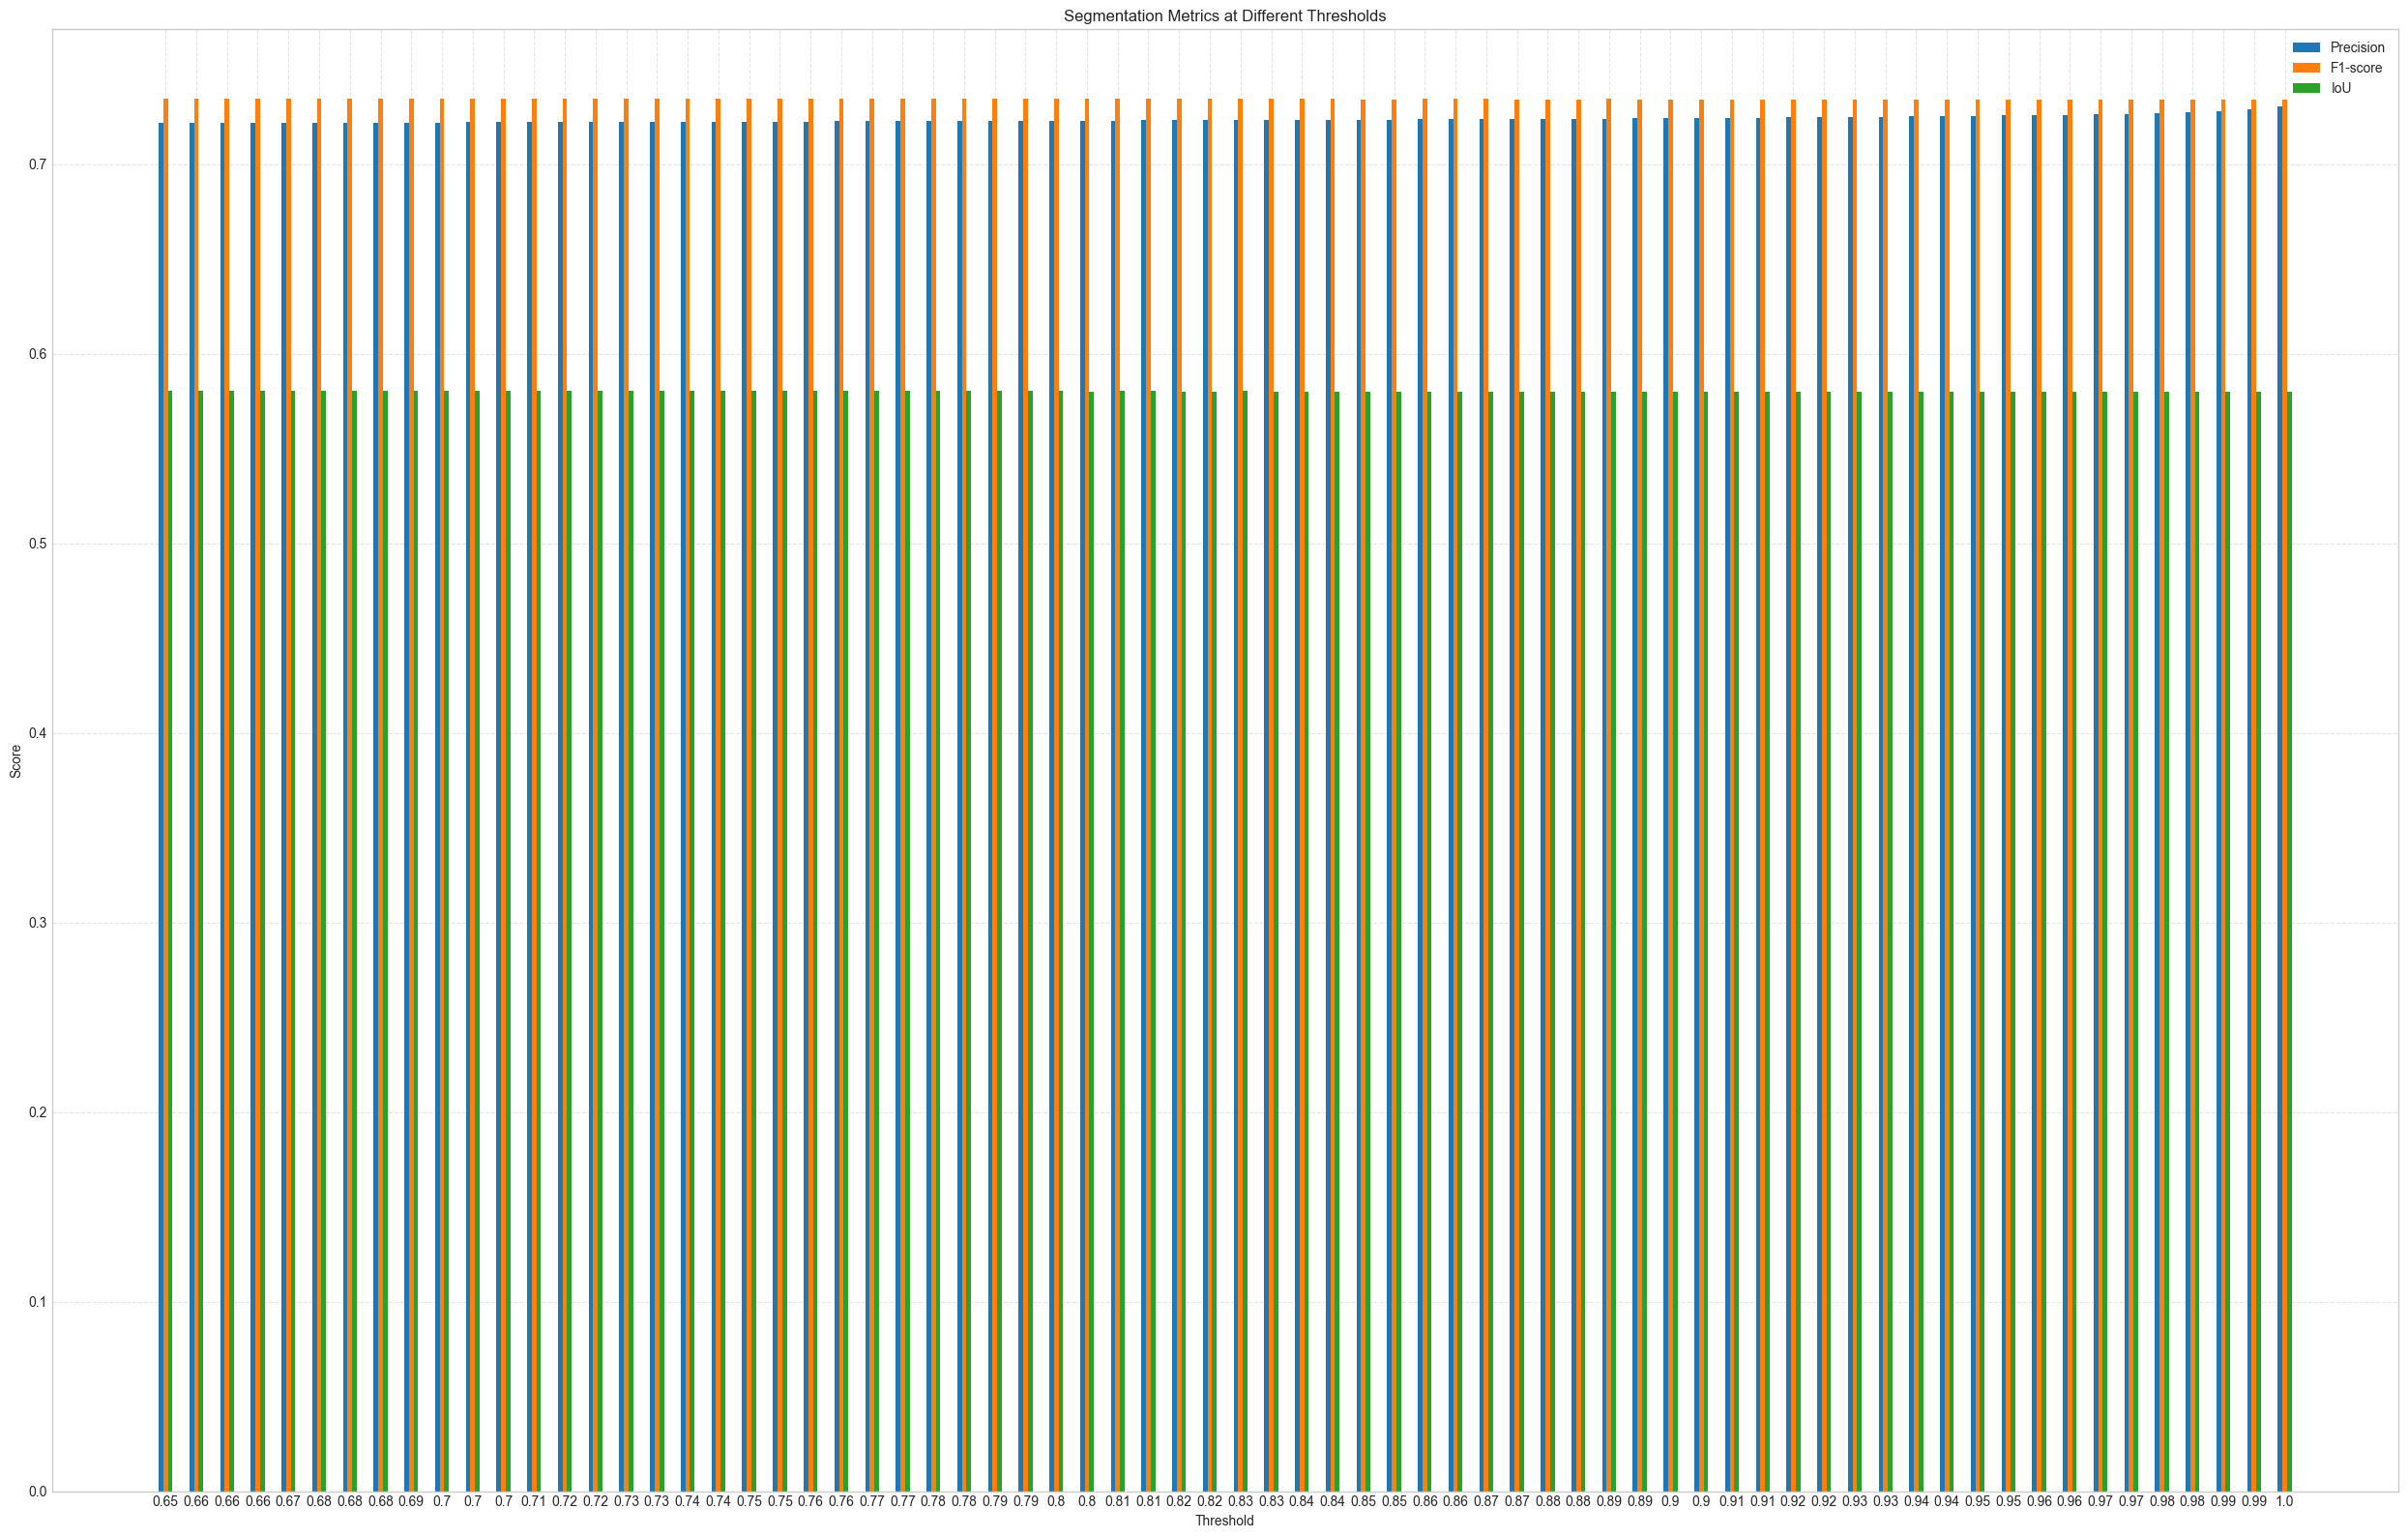

In [9]:
x = [round(t, 2) for t in metrics['threshold']]
x_idx = np.arange(len(x))
width = 0.15

plt.figure(figsize=(25, 16))
plt.bar(x_idx - width, metrics['precision'], width=width, label='Precision')
plt.bar(x_idx, metrics['f1'], width=width, label='F1-score')
plt.bar(x_idx + width, metrics['iou'], width=width, label='IoU')

plt.xticks(x_idx, x)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Segmentation Metrics at Different Thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()